In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
from google.colab import files
uploaded = files.upload()

Saving strictly_balanced_movies.csv to strictly_balanced_movies.csv


In [3]:
df = pd.read_csv('/content/strictly_balanced_movies.csv')


mlb = MultiLabelBinarizer()

mlb.fit(df['genres'])

one_hot_labels = mlb.transform(df['genres'])


genre_columns = mlb.classes_
one_hot_df = pd.DataFrame(one_hot_labels, columns=genre_columns)

df = pd.concat([df, one_hot_df], axis=1)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
class MovieGenreDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = self.tokenizer(
        row['overview'],
        truncation=True,
        padding='max_length',
        max_length=self.max_len,
        return_tensors='pt'
    )

        labels = torch.tensor(row[genre_columns].astype('float32').values)

        return {
              'input_ids': encoding['input_ids'].squeeze(0),
              'attention_mask': encoding['attention_mask'].squeeze(0),
              'labels': labels
    }

In [5]:
model_name = "bert-base-uncased"
num_labels = len(genre_columns)

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from sklearn.metrics import accuracy_score, f1_score

def train(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        optimizer.zero_grad()


        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()


        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']


            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits


            preds = (torch.sigmoid(logits) > 0.5).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())


    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='micro')

    return acc, f1


In [ ]:
train_dataset = MovieGenreDataset(df, tokenizer, max_len=256)
test_dataset = MovieGenreDataset(test_df, tokenizer, max_len=256)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train_loss = train(model, train_loader, optimizer, criterion)
    acc, f1 = evaluate(model, test_loader)
    print(f"Train Loss: {train_loss:.4f} | Acc: {acc:.4f} | F1 : {f1:.4f}")

Epoch 1
Train Loss: 0.4686 | Acc: 0.1136 | F1 : 0.7326
Epoch 2
Train Loss: 0.3859 | Acc: 0.1835 | F1 : 0.7915
Epoch 3
Train Loss: 0.3324 | Acc: 0.2748 | F1 : 0.8431
Epoch 4
Train Loss: 0.2787 | Acc: 0.4417 | F1 : 0.8849
Epoch 5
Train Loss: 0.2272 | Acc: 0.5095 | F1 : 0.9117


In [8]:
import pickle

bert_vocab = tokenizer.get_vocab()

with open("bert_vocab.pkl", "wb") as f:
    pickle.dump(bert_vocab, f)

In [9]:

embedding_matrix = model.bert.embeddings.word_embeddings.weight.detach().cpu().numpy()

np.save("bert_embedding_matrix.npy", embedding_matrix)

In [10]:
torch.save(model.state_dict(), "bert_multilabel_model.pth")

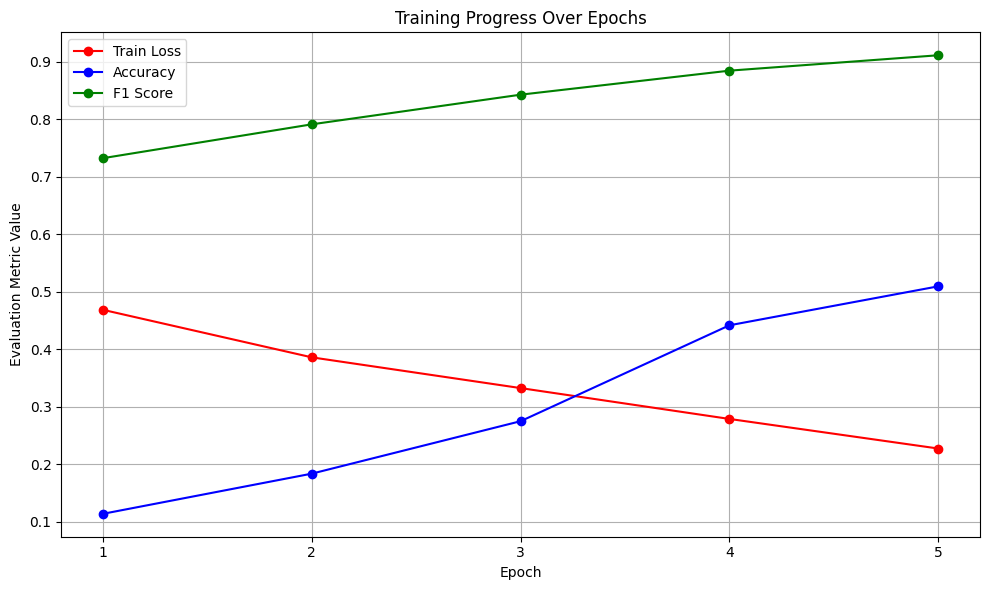

In [ ]:

import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5]
train_loss = [0.4686, 0.3859, 0.3324, 0.2787, 0.2272]
accuracy = [0.1136, 0.1835, 0.2748, 0.4417, 0.5095]
f1_score = [0.7326, 0.7915, 0.8431, 0.8849, 0.9117]

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss, label='Train Loss', marker='o', color='red')
plt.plot(epochs, accuracy, label='Accuracy', marker='o', color='blue')
plt.plot(epochs, f1_score, label='F1 Score', marker='o', color='green')

plt.title("Training Progress Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Evaluation Metric Value")
plt.xticks(epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import hamming_loss, f1_score, accuracy_score

micro_f1 = f1_score(y_true, y_pred, average='micro')
macro_f1 = f1_score(y_true, y_pred, average='macro')
subset_acc = accuracy_score(y_true, y_pred)
hamming = hamming_loss(y_true, y_pred)

print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Subset Accuracy: {subset_acc:.4f}")


Micro F1: 0.9117
Macro F1: 0.8856
Subset Accuracy: 0.5095


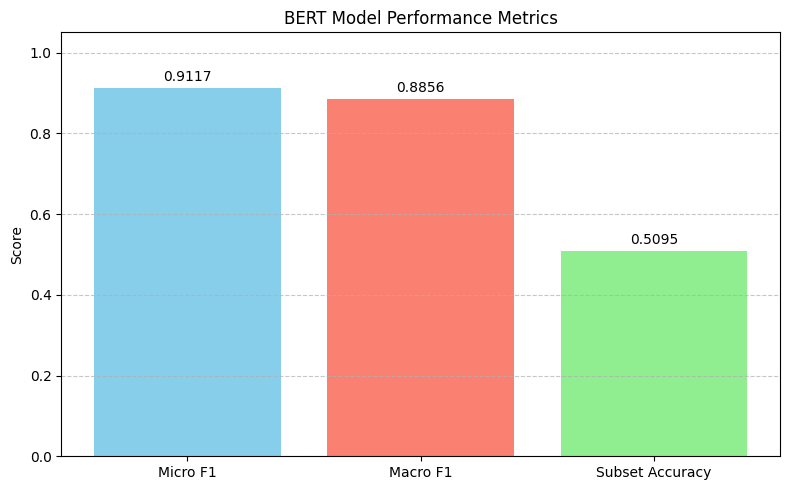

In [25]:
import matplotlib.pyplot as plt

metrics = ['Micro F1', 'Macro F1', 'Subset Accuracy']
scores = [0.9117, 0.8856, 0.5095]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=['skyblue', 'salmon', 'lightgreen'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')

plt.ylim(0, 1.05)
plt.title('BERT Model Performance Metrics')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
